# Variational Autoencoder

In [1]:
import logging
import torch 

from aicraft.utils.loaders import FashionMNISTLoader
from aicraft.utils.visualise import Visualisations
from aicraft.models.vae.encoder import Encoder
from aicraft.models.vae.decoder import Decoder
from aicraft.models.vae.sampling import Sampling
from aicraft.models.vae.model import VariationalAutoEncoder
from aicraft.utils.loss import CustomLosses
from aicraft.models.AutoEncoderTrainers import VaeTrainer

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

DEBUG_MODE = True

if torch.cuda.is_available():
    logger.info("Using GPU")
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    logger.info("Using MPS")
    device = torch.device("mps")
else:
    logger.info("Using CPU")
    device = torch.device("cpu")

device

INFO:__main__:Using MPS


device(type='mps')

## Load data and visualise

In [2]:
data = FashionMNISTLoader(val_split=0.1)
train_loader, validation_loader, test_loader = data.get_loaders()
label_mapper = {v: k for k, v in test_loader.dataset.class_to_idx.items()}
logger.info(f"Train: {len(train_loader)} Validation: {len(validation_loader)} Test: {len(test_loader)}")

INFO:__main__:Train: 1174 Validation: 131 Test: 218


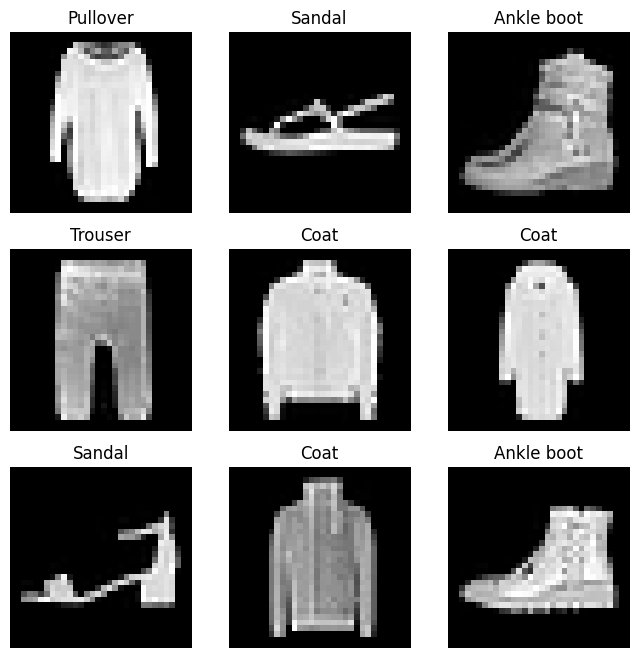

In [3]:
Visualisations.show_images(data.train)

## Defining a Variational Autoencoder

In [4]:
vae = VariationalAutoEncoder(embedding_size=2)
_encoder = Encoder(embedding_size=2)
_decoder = Decoder(embedding_size=2)
_sampler = Sampling()

In [5]:
_batch, _labels = next(iter(train_loader))

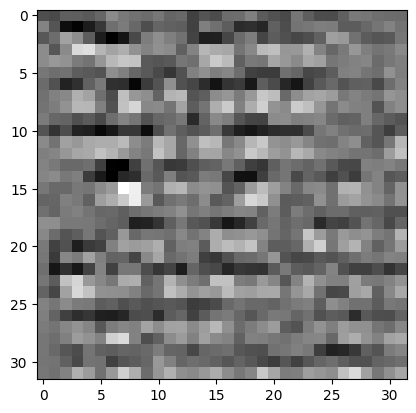

In [6]:
mu, log_var = _encoder(_batch)
z = _sampler(mu, log_var)
_batch_reconstructed = _decoder(z)
Visualisations.show_image(_batch_reconstructed[0])

In [7]:
_l = CustomLosses.vae_loss(_batch_reconstructed, _batch, mu, log_var)
logger.info(f"Loss: {_l}")

INFO:__main__:Loss: (tensor(360.5471, grad_fn=<AddBackward0>), tensor(360.1981, grad_fn=<MulBackward0>), tensor(0.3491, grad_fn=<MeanBackward0>))


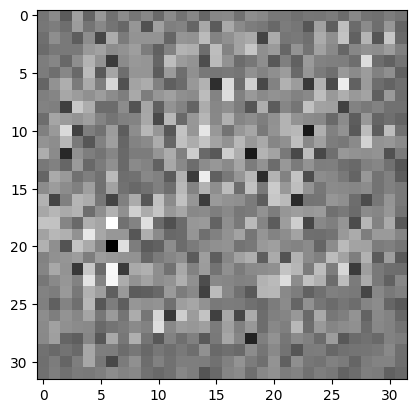

In [8]:
mu, sigma, _batch_reconstructed = vae(_batch)
Visualisations.show_image(_batch_reconstructed[0])

## Training

In [9]:
optimiser = torch.optim.Adam(vae.parameters(), lr=0.001)
step_scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=10, gamma=0.5)
exponential_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=0.99)
VaeTrainer.train(
    tl=train_loader, 
    vl=validation_loader, 
    model=vae, 
    loss_fn=CustomLosses.vae_loss, 
    optimiser=optimiser, 
    scheduler=step_scheduler, 
    epochs=20, 
    device=device
)

VAE Training: 100%|██████████| 1174/1174 [00:18<00:00, 62.31it/s]
INFO:aicraft.models.AutoEncoderTrainers:Epoch 1, Loss: 262.80159140851674, Validation Loss: 216.14580751375388
INFO:aicraft.models.AutoEncoderTrainers:LRs for epoch 1: [0.001]
VAE Training: 100%|██████████| 1174/1174 [00:18<00:00, 65.03it/s]
INFO:aicraft.models.AutoEncoderTrainers:Epoch 2, Loss: 192.29835263305873, Validation Loss: 174.2860869196535
INFO:aicraft.models.AutoEncoderTrainers:LRs for epoch 2: [0.001]
VAE Training: 100%|██████████| 1174/1174 [00:17<00:00, 65.24it/s]
INFO:aicraft.models.AutoEncoderTrainers:Epoch 3, Loss: 163.6454863670128, Validation Loss: 155.21371378425422
INFO:aicraft.models.AutoEncoderTrainers:LRs for epoch 3: [0.001]
VAE Training: 100%|██████████| 1174/1174 [00:17<00:00, 66.36it/s]
INFO:aicraft.models.AutoEncoderTrainers:Epoch 4, Loss: 149.7756550543556, Validation Loss: 146.03439540717437
INFO:aicraft.models.AutoEncoderTrainers:LRs for epoch 4: [0.001]
VAE Training: 100%|██████████| 1174

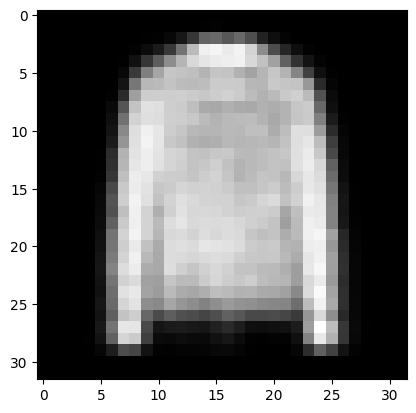

In [10]:
t_mu, t_sigma, _batch_reconstructed = vae(_batch.to(device))
Visualisations.show_image(_batch_reconstructed[0])

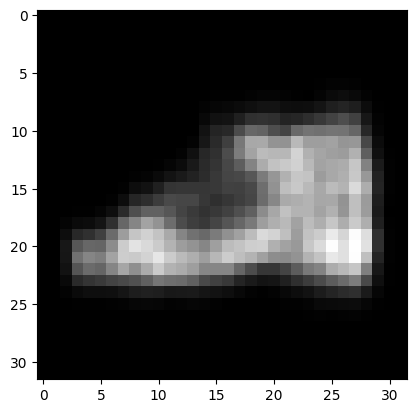

In [11]:
mu, log_var = vae.encoder(_batch.to(device))
z = _sampler(mu, log_var)
_batch_reconstructed = vae.decoder(z)
Visualisations.show_image(_batch_reconstructed[11])

In [12]:
z, l, mu, sigma = vae.generate_embedding(test_loader, device)
_test_reconstructed_from_sample = vae.decoder(z)

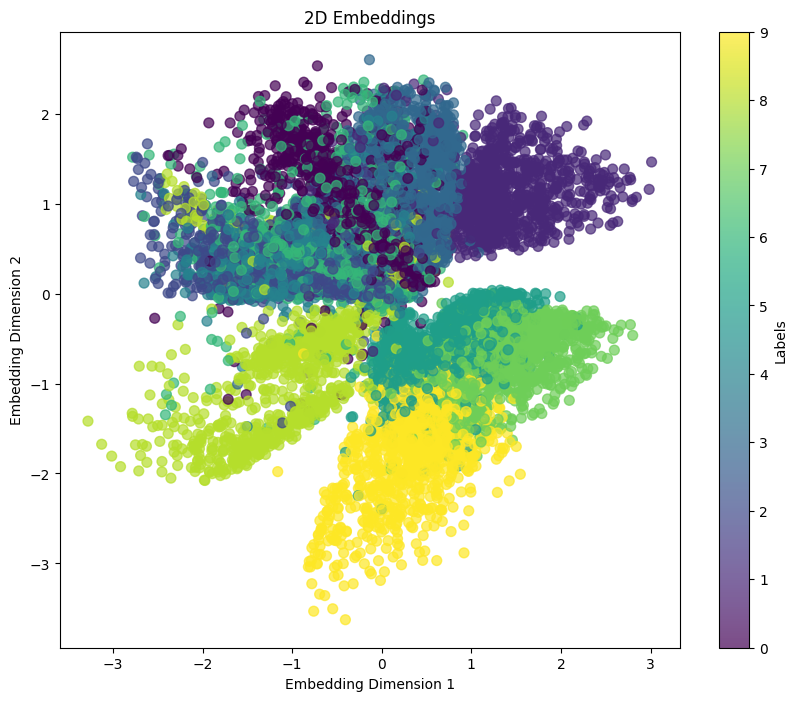

In [13]:
Visualisations.plot_2d_embeddings(mu, l)

## Generating New Images

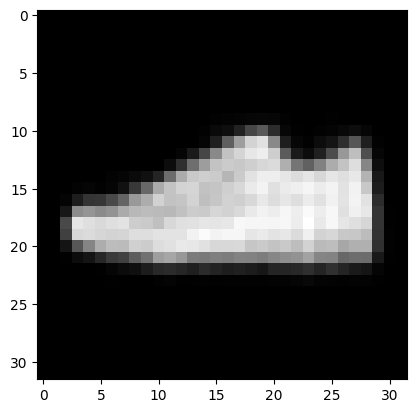

In [58]:
Visualisations.show_image(vae.decoder(torch.tensor([(1.83, -1.1502)]).to(device)))